# Gradient Matching Attack on a TF Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Tensorflow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [1]:
import numpy as np
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25):
    model = Sequential([
        tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    datagen.fit(x_train)
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1)
    return model

model = create_model(x_train, y_train, epochs=25)
model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

2021-12-16 05:58:19.883769: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-16 05:58:21.093562: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-16 05:58:21.094512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-16 05:58:22.575628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 05:58:22.576545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-16 05:58:22.576635: I tensorflow/stream_executor/cuda/cuda_gpu_

Epoch 1/25


2021-12-16 05:58:30.464808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-16 05:58:30.725435: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


781/781 [==============================] - 29s 30ms/step - loss: 2.3600 - accuracy: 0.2763
Epoch 2/25
781/781 [==============================] - 22s 29ms/step - loss: 1.8923 - accuracy: 0.3857
Epoch 3/25
781/781 [==============================] - 22s 28ms/step - loss: 1.9936 - accuracy: 0.3581
Epoch 4/25
781/781 [==============================] - 23s 29ms/step - loss: 1.7672 - accuracy: 0.3939
Epoch 5/25
781/781 [==============================] - 22s 28ms/step - loss: 1.7086 - accuracy: 0.4353
Epoch 6/25
781/781 [==============================] - 23s 29ms/step - loss: 1.6696 - accuracy: 0.4630
Epoch 7/25
781/781 [==============================] - 22s 28ms/step - loss: 1.6858 - accuracy: 0.4481
Epoch 8/25
781/781 [==============================] - 23s 29ms/step - loss: 1.5883 - accuracy: 0.4850
Epoch 9/25
781/781 [==============================] - 22s 29ms/step - loss: 1.4485 - accuracy: 0.5200
Epoch 10/25
781/781 [==============================] - 22s 28ms/step - loss: 1.3718 - accurac

## Choose Target Image from Test Set

In [2]:
from tensorflow.keras.utils import to_categorical

# A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

# Trigger sample
x_trigger = x_test[index_target:index_target+1]
y_trigger  = to_categorical([class_target], num_classes=10)

## Poison Training Images to Misclassify the Trigger Image


In [3]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

epsilson = 0.1/(std+1e-7)

attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=3,
        max_epochs=200,
        clip_values=(min_,max_),
        epsilon=epsilson,
        verbose=False)

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


  0%|          | 0/3 [00:00<?, ?it/s]

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
  <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_0_conv/kernel:0' shape=(1, 1, 64, 256) dtype=float32>
  <tf.Variable 'conv2_block1_0_conv/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'conv2_block1_0_bn/gamma:0' shape=(256,) dtype=float32>
  <tf.Variable 'conv2_block1_0_bn/beta:0' shape=(256,) dtype=float32>
  <tf.Variable 'conv2_block1_1_conv/kernel:0' shape=(1, 1, 64, 64) dtype=float32>
  <tf.Variable 'conv2_block1_1_conv/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_1_bn/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2_block1_2_conv/kernel:0'

## Examples of the trigger, an original sample, and the poisoned sample

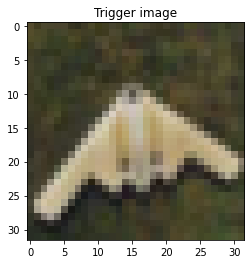

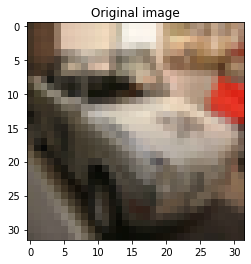

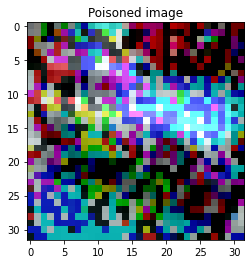

In [14]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [15]:
model_poisoned = create_model(x_poison, y_poison, epochs=25)
y_ = model_poisoned.predict(x_trigger)

print("y_trigger:", y_trigger)
print("y_:", y_)

Epoch 1/25
781/781 [==============================] - 26s 28ms/step - loss: 2.2994 - accuracy: 0.2878
Epoch 2/25
781/781 [==============================] - 23s 29ms/step - loss: 1.8936 - accuracy: 0.3786
Epoch 3/25
781/781 [==============================] - 25s 31ms/step - loss: 1.8513 - accuracy: 0.4073
Epoch 4/25
781/781 [==============================] - 23s 29ms/step - loss: 1.9693 - accuracy: 0.3656
Epoch 5/25
682/781 [=========================>....] - ETA: 2s - loss: 1.9098 - accuracy: 0.3579